In [8]:
from search import MCTS, UniformCostSearch
from utils.cities import Cities
from utils.state import SearchState

import yaml
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

In [9]:
cities = Cities().getCities()
keys = list(cities.keys())

iterations = 8
observedParameter = "expWeight"
decr = 0.1

# Dataset
For experimentation, a smaller instance of the travelling salesman problem derived from [TSPLIB](https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html) was used. The dataset consists of 10 cities, represented by numbers from 1 to 10, and their corresponding x, y coordinates. The cost between two cities, given their Cartesian coordinates, is the Euclidean distance between them. The distribution of the cities is shown below.

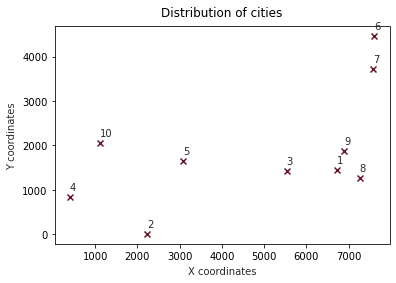

In [3]:
x, y = zip(*cities.values())
    
for city, (locX, locY) in cities.items():
    plt.annotate(city, (locX, locY + 150), color = "#292929")

plt.xlabel("X coordinates", color = "#292929", labelpad = 5)
plt.ylabel("Y coordinates", color = "#292929", labelpad = 5)
plt.title("Distribution of cities", pad = 10)

plt.scatter(x, y, color = "#661728", marker = "x")

A random tour of the cities discovers a path with the following cost. This value is obtained by calculating the cost of the path obtained by taking the cities in a random order, and averaging the costs of `iter` number of executions. 

In [5]:
from random import shuffle

cost = 0
iter = 10

def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return ((x1 - x2)**2 + (y1 - y2)**2) ** 0.5

for _ in range(iter):
    currCost = 0
    citiesList = list(cities.items())
    shuffle(citiesList)

    for i in range(len(citiesList) - 1):
        currCost += dist(citiesList[i][1], citiesList[i + 1][1])
    
    cost += currCost
    
cost = cost/iter

cost

38313.16201118917

# Uniform Cost Search
Using uniform cost, we get the following path. We consider the cities as vertices and each edge represents the path to take from one city to the other, weighted by the euclidean distance between the two cities. 

In [4]:
startState = SearchState([keys[0]], [city for city in cities.keys() if city != keys[0]])

search = UniformCostSearch(printGraph = False, logEnable = False)
path, stats = search.findPath(startState)

print(path, "\n\n")
print(stats.toPrettyString())

[1, 3, 2, 4, 10, 5, 6, 7, 9, 8, 1] 


Total time(HH:MM:SS)	Nodes expanded	Cost of route
0:05:21.112614		114498		19520.29934284165


The search tree generated by this run can be viewed below. It is apparent that the tree has an almost symmetric growth, as uniform cost search explores the search space in a greedy manner.

In [9]:
from IPython.display import IFrame
IFrame(src='./graphUcs.html', width=700, height=600)

# Monte Carlo Tree Search (MCTS)
Next, we apply the MCTS algorithm to the same problem. This approach involves randomly sampling the search space and directing the search tree growth to more promising subtrees. In this implementation of MCTS, simulations are played out in a *rollout* phase. The rollout phase is following by a *visit* operation, in which the next city to visit is picked. This process is repeated until we pick all the cities are picked and we return to the starting city.

This implementation of MCTS is parameterized by
- exploration weight: Controls how new search nodes are expanded by balancing exploration and exploitation.
- number of rollouts: The number of simulations played out by the algorithm before picking each successive move.

In [20]:
argsMcts = {
    "expWeight": 1,
    "rewardWeight": 1,
    "noIterationsRollout": 1000,
    "printGraph": True,
    "logEnable": False
}

In [21]:
startState = SearchState([keys[0]], [city for city in cities.keys() if city != keys[0]])
path, stats = MCTS(**argsMcts.copy()).findPath(startState)

print(path, "\n\n")
print(stats.toPrettyString())

[1, 8, 6, 7, 3, 5, 2, 4, 9, 10, 1] 


Total time(HH:MM:SS)	Nodes expanded	Cost of route
0:07:05.538350		4242		31916.978165948167


The search tree generated by the MCTS algorithm can be seen below.

In [26]:
from IPython.display import IFrame
IFrame(src='./graphMcts.html', width=700, height=600)

## Simple Reward 
The reward function evaluates a terminal state and returns an associated reward depending on whether the terminal state is a win or a loss. In the context of the travelling salesman problem, where there is no clear concept of a win or loss, an appropriate reward mechanism needs to be implemented.

We use a simple reward function that compares the cost to be evaluated to the best cost seen so far. If the current path is better than the best path seen so far, it gets a reward of 1. Otherwise, the reward is 0.

In [11]:
def execute(search, args, observedParameter):
    currArgs = args.copy()
    val = currArgs[observedParameter]
    costs = []
    durations = []
    nodes = []
    
    while val >= 0:
        print(observedParameter, val)
        totalCost = 0
        totalNodes = 0
        totalDuration = 0

        startState = SearchState([keys[0]], [city for city in cities.keys() if city != keys[0]])
        for i in range(iterations):
            print("Find path iteration: ", i)
            
            path, stats = search(**currArgs).findPath(startState)
            totalCost += stats.totalCost
            totalDuration += stats.totalTime
            totalNodes += stats.nodeCount

        averageCost = totalCost / iterations
        averageDuration = totalDuration / iterations
        averageNode = totalNodes / iterations

        print(averageCost, averageDuration, averageNode)
        costs.append(averageCost)
        durations.append(averageDuration)
        nodes.append(averageNode)
        val -= decr

    return costs, durations, nodes

Below, we examine how the exploration weight parameter affects the quality of the solutions generated by MCTS.

In [27]:
argsMcts['expWeight'] = 2
argsMcts['noIterationsRollout'] = 200
costs, durations, nodes = execute(MCTS, argsMcts, "expWeight")

expWeight 2
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
24724.07220868203 18.07809026572795 1025.0
expWeight 1.9
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
31541.164172804278 18.113741145891254 1032.75
expWeight 1.7999999999999998
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
27536.71330577546 18.043660817915224 1009.875
expWeight 1.6999999999999997
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
32884.8474323

<Figure size 432x288 with 0 Axes>

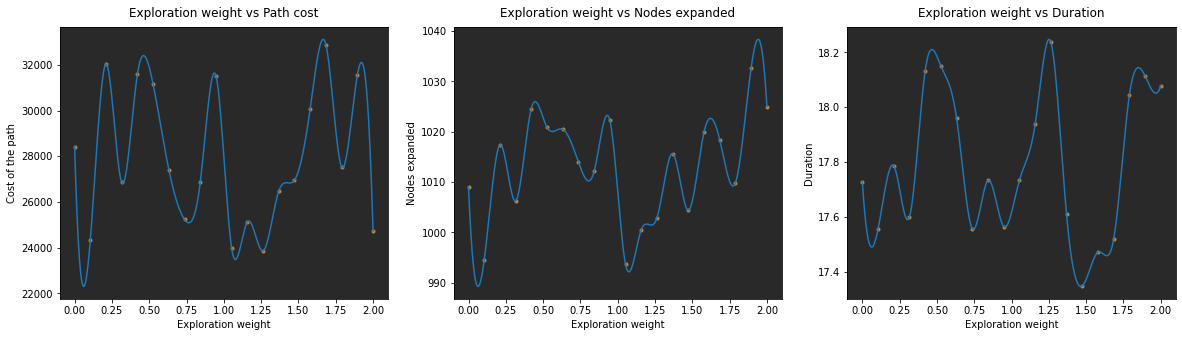

In [42]:
plt.clf()
x = np.linspace(2, 0, 20)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# scatter plots
ax1.scatter(x, costs, marker = ".", color = "#c78438")
ax2.scatter(x, nodes, marker = ".", color = "#c78438")
ax3.scatter(x, durations, marker = ".", color = "#c78438")

#trend curves
from scipy.interpolate import interp1d
cubic_interpolation_model_costs = interp1d(x, costs, kind = "cubic")
cubic_interpolation_model_nodes = interp1d(x, nodes, kind = "cubic")
cubic_interpolation_model_durations = interp1d(x, durations, kind = "cubic")

X_ = np.linspace(x.min(), x.max(), 500)
ax1.plot(X_, cubic_interpolation_model_costs(X_))
ax2.plot(X_, cubic_interpolation_model_nodes(X_))
ax3.plot(X_, cubic_interpolation_model_durations(X_))

ax1.set(xlabel = "Exploration weight", ylabel = "Cost of the path", facecolor = "#292929")
ax1.set_title("Exploration weight vs Path cost", pad = 10)

ax2.set(xlabel = "Exploration weight", ylabel = "Nodes expanded", facecolor = "#292929")
ax2.set_title("Exploration weight vs Nodes expanded", pad = 10)

ax3.set(xlabel = "Exploration weight", ylabel = "Duration", facecolor = "#292929")
ax3.set_title("Exploration weight vs Duration", pad = 10)

plt.show()

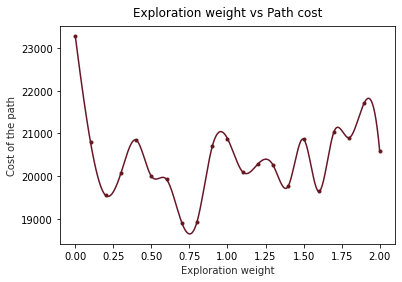

In [115]:
# scatter plot
plt.scatter(expWeights, costs, marker = ".", color = "#661717")

#trend curve
from scipy.interpolate import interp1d
cubic_interpolation_model = interp1d(expWeights, costs, kind = "cubic")
X_=np.linspace(expWeights.min(), expWeights.max(), 500)
Y_=cubic_interpolation_model(X_)
plt.plot(X_, Y_, color="#661728")

plt.xlabel("Exploration weight", color = "#292929")
plt.ylabel("Cost of the path", color = "#292929")
plt.title("Exploration weight vs Path cost", pad = 10)

plt.show()

## Reward with Inner Function
To gain better insights from the explored search space, an alternate reward function is also implemented. The idea is that if a path is sufficiently good, then it can stimulate diversification so that more area of the search space can be covered.

A hyperbolic inner function is chosen, in such a way that promising results are promoted while the average and poor ones are discarded.

### Case 1
sufficiencyThreshold = 1

In [12]:
argsMcts['expWeight'] = 2
costs, durations, nodes = execute(MCTS, argsMcts, "expWeight")

expWeight 2
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
31224.400489965763 14.872286287501993 1039.5
expWeight 1.9
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
25722.710883863223 15.041304774999844 1039.125
expWeight 1.7999999999999998
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
25705.747214758383 14.859114174998467 1037.625
expWeight 1.6999999999999997
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
27081.386

<Figure size 432x288 with 0 Axes>

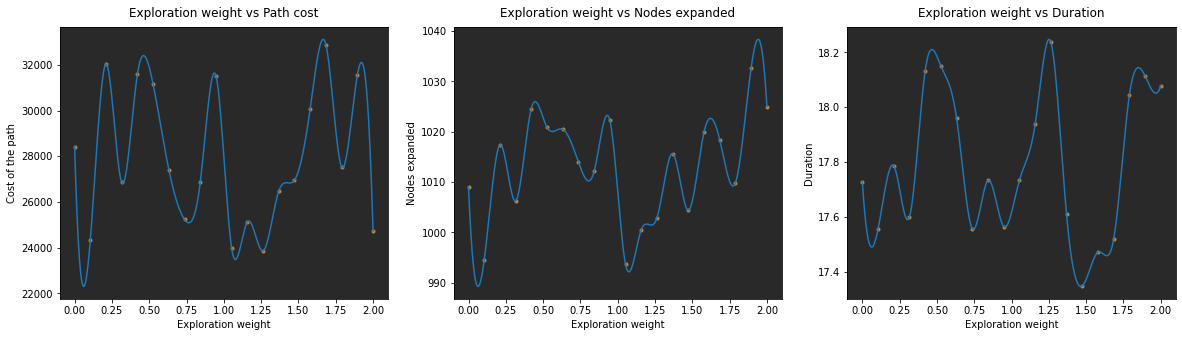

In [14]:
plt.clf()
x = np.linspace(2, 0, 20)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# scatter plots
ax1.scatter(x, costs, marker = ".", color = "#c78438")
ax2.scatter(x, nodes, marker = ".", color = "#c78438")
ax3.scatter(x, durations, marker = ".", color = "#c78438")

#trend curves
from scipy.interpolate import interp1d
cubic_interpolation_model_costs = interp1d(x, costs, kind = "cubic")
cubic_interpolation_model_nodes = interp1d(x, nodes, kind = "cubic")
cubic_interpolation_model_durations = interp1d(x, durations, kind = "cubic")

X_ = np.linspace(x.min(), x.max(), 500)
ax1.plot(X_, cubic_interpolation_model_costs(X_))
ax2.plot(X_, cubic_interpolation_model_nodes(X_))
ax3.plot(X_, cubic_interpolation_model_durations(X_))

ax1.set(xlabel = "Exploration weight", ylabel = "Cost of the path", facecolor = "#292929")
ax1.set_title("Exploration weight vs Path cost", pad = 10)

ax2.set(xlabel = "Exploration weight", ylabel = "Nodes expanded", facecolor = "#292929")
ax2.set_title("Exploration weight vs Nodes expanded", pad = 10)

ax3.set(xlabel = "Exploration weight", ylabel = "Duration", facecolor = "#292929")
ax3.set_title("Exploration weight vs Duration", pad = 10)

plt.show()

### Case 2
sufficiencyThreshold > 1

In [25]:
argsMcts['rewardWeight'] = 1.5
argsMcts['expWeight'] = 2
argsMcts['noIterationsRollout'] = 200
argsMcts['printGraph'] = True
costs, durations, nodes = execute(MCTS, argsMcts, "expWeight")

expWeight 2
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
21266.521146085473 15.223476499999379 1029.125
expWeight 1.9
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
21586.581314971998 15.696478999998362 1028.5
expWeight 1.7999999999999998
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
21351.386893223465 16.405848287497065 1030.625
expWeight 1.6999999999999997
Find path iteration:  0
Find path iteration:  1
Find path iteration:  2
Find path iteration:  3
Find path iteration:  4
Find path iteration:  5
Find path iteration:  6
Find path iteration:  7
20884.664

<Figure size 432x288 with 0 Axes>

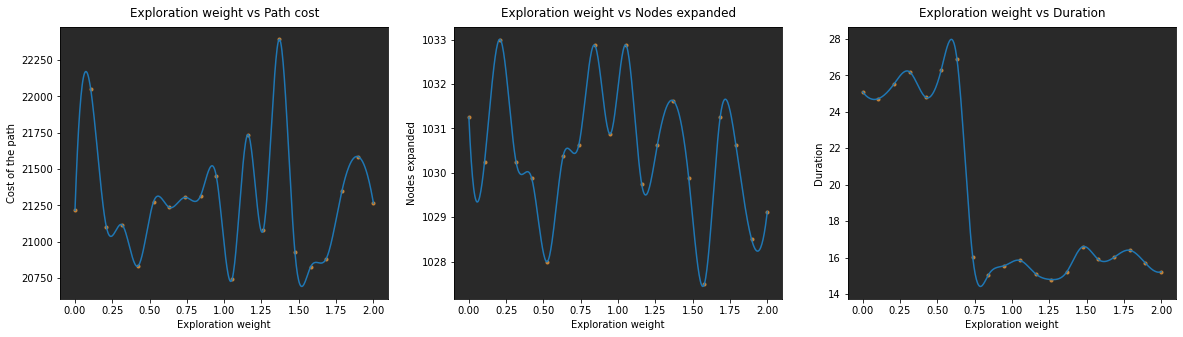

In [28]:
plt.clf()
x = np.linspace(2, 0, 20)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# scatter plots
ax1.scatter(x, costs, marker = ".", color = "#c78438")
ax2.scatter(x, nodes, marker = ".", color = "#c78438")
ax3.scatter(x, durations, marker = ".", color = "#c78438")

#trend curves
from scipy.interpolate import interp1d
cubic_interpolation_model_costs = interp1d(x, costs, kind = "cubic")
cubic_interpolation_model_nodes = interp1d(x, nodes, kind = "cubic")
cubic_interpolation_model_durations = interp1d(x, durations, kind = "cubic")

X_ = np.linspace(x.min(), x.max(), 500)
ax1.plot(X_, cubic_interpolation_model_costs(X_))
ax2.plot(X_, cubic_interpolation_model_nodes(X_))
ax3.plot(X_, cubic_interpolation_model_durations(X_))

ax1.set(xlabel = "Exploration weight", ylabel = "Cost of the path", facecolor = "#292929")
ax1.set_title("Exploration weight vs Path cost", pad = 10)

ax2.set(xlabel = "Exploration weight", ylabel = "Nodes expanded", facecolor = "#292929")
ax2.set_title("Exploration weight vs Nodes expanded", pad = 10)

ax3.set(xlabel = "Exploration weight", ylabel = "Duration", facecolor = "#292929")
ax3.set_title("Exploration weight vs Duration", pad = 10)

plt.show()